
## **Introducción**

Este notebook presenta el desarrollo de un proyecto para la asignatura **"Ciencia de Datos para la Gestión de Información No Estructurada"**, cuyo objetivo es construir un modelo de clasificación de texto que sea capaz de identificar si un mensaje SMS es **spam** o **legítimo (ham)**.

Para llevar a cabo este trabajo, se ha utilizado material proporcionado en clase, complementado con investigación autónoma por parte del alumno a través de videos educativos y foros especializados.

El código base se ha adaptado a partir del video del canal **Pythonology**:  
🔗 [YouTube - Simple SMS Spam Classifier](https://www.youtube.com/watch?v=eOu-h_XxjHQ)

El dataset utilizado proviene de Kaggle:  
📊 [Kaggle - SMS Spam Detection Dataset](https://www.kaggle.com/code/amirhosseinmirzaie/simple-sms-spam-detection-text-classification/input)

El proyecto completo, incluyendo el código fuente y recursos adicionales, se encuentra disponible en el siguiente repositorio de GitHub:  
📁 [GitHub - sms-spam-classification](https://github.com/Ocaam/sms-spam-classification.git)

El objetivo principal de este proyecto es **desarrollar y comparar diferentes modelos de clasificación de texto** para detectar mensajes SMS considerados como **spam**.

En particular, se pretende evaluar el rendimiento de tres algoritmos ampliamente utilizados en problemas de clasificación de texto:

- **Multinomial Naive Bayes (MultinomialNB)**  
- **Complement Naive Bayes (ComplementNB)**  
- **Máquina de Vectores de Soporte Lineal (LinearSVC)**

Se analizará cómo se comporta cada uno de estos modelos sobre el dataset de SMS en términos de **precisión**, **recall**, **F1-score** y otras métricas relevantes, con el fin de identificar cuál de ellos resulta más adecuado para esta tarea de detección de spam en mensajes cortos y no estructurados.

Además, se aplicarán técnicas estándar de procesamiento de lenguaje natural (NLP) para preparar los datos antes de alimentar los modelos, como la **vectorización** de texto con `TfidfVectorizer` y, adicionalmente propuesto por el docente, `CountVectorizer`, y la **estratificación** durante la separación del conjunto de datos para asegurar una evaluación justa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

seed = 1441

In [2]:
df = pd.read_csv("../data/train.csv")

In [ ]:
#!pip install -r ../env/requirements.txt

In [3]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Este dataset contiene dos columnas, una el mensaje de texto (SMS) y otra la etiqueta 'label' donde cada sms queda etiquetado etiquetado con:
- `0`: mensaje normal
- `1`: mensaje clasificado como **spam**

In [4]:
df["label"].value_counts()

label
0    4827
1     747
Name: count, dtype: int64

## **Distribución de Clases**

El dataset está compuesto por un total de **5,574 mensajes SMS**, distribuidos de la siguiente manera:

- **Mensajes reales:** 4,827  
- **Mensajes spam:** 747

Como puede observarse, el conjunto de datos está **desequilibrado**, con una mayoría significativa de mensajes reales frente a los mensajes clasificados como spam.

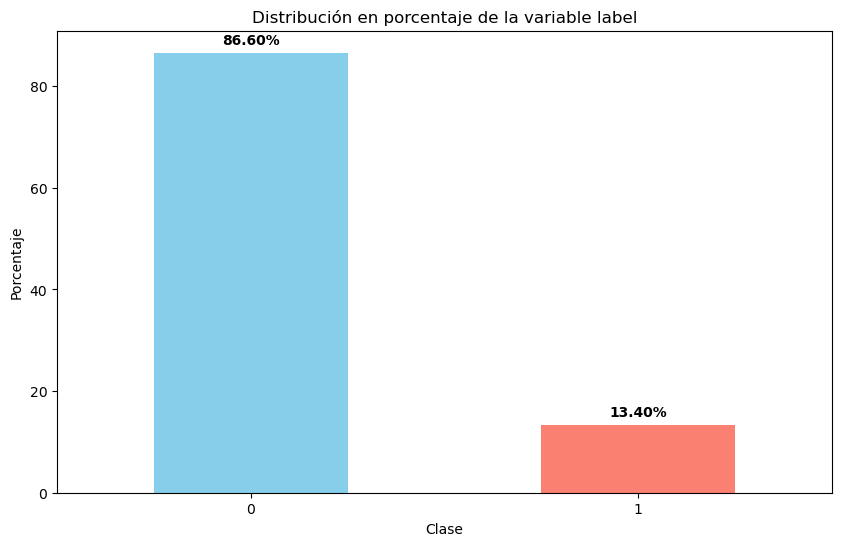

In [5]:
label_percentage = df["label"].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 6))
ax = label_percentage.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución en porcentaje de la variable label')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)

for i, v in enumerate(label_percentage):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

### **A través del gráfico anterior podemos ver, a nivel porcentual, la distribución de las clases**

In [6]:
X = df["sms"]
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df['label'],random_state=seed)

In [8]:
X_train.shape, X_test.shape

((3901,), (1673,))

In [9]:
print('== Train\n', df['label'].value_counts(normalize=True))
print('== Test\n', df['label'].value_counts(normalize=True))

== Train
 label
0    0.865985
1    0.134015
Name: proportion, dtype: float64
== Test
 label
0    0.865985
1    0.134015
Name: proportion, dtype: float64


##  **División del Conjunto de Datos**

Se realiza una separación del dataset en conjuntos de **entrenamiento (train)** y **prueba (test)**, utilizando una proporción del **70% para entrenamiento** y **30% para prueba**.

Además, se aplica **estratificación**, lo que garantiza que la proporción de mensajes de cada clase (spam y ham) se mantenga constante tanto en el conjunto de entrenamiento como en el de prueba.

Esto es especialmente importante debido al **desequilibrio en las clases**.  
Si no se aplicara estratificación, podría ocurrir que el conjunto de prueba contenga **muy pocos (o ningún)** mensajes de la clase minoritaria (spam), lo cual afectaría negativamente al entrenamiento y evaluación del modelo.

Con la estratificación, se asegura una representación justa y proporcional de ambas clases en ambos subconjuntos.


La siguiente función, la cual he reciclado de otra práctica de una asignatura de aprendizaje automático que se puede encontrar en el notebook del siguiente repositorio: https://github.com/Ocaam/practica_ApAu/blob/main/notebooks/03_encoding_categorical_scaled_vars_and_model.ipynb


In [10]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(20,6)):
    """
    ----------------------------------------------------------------------------------------------------------
    Función: plot_confusion_matrix
    ----------------------------------------------------------------------------------------------------------
    - Descripción:
        Esta función genera una visualización de la matriz de confusión, basada en los valores reales y 
        predichos de la variable objetivo, tanto en valores absolutos como en su forma normalizada.

    - Parámetros de entrada:
        - y_true: Array o Serie que contiene los valores reales de la variable objetivo (por ejemplo, y_test o y_val).
        - y_pred: Array o Serie con los valores predichos por el modelo.
        - title: Título del gráfico.
        - figsize: Tupla que especifica el tamaño deseado para las gráficas combinadas.
    """    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(y_true, y_pred, cmap='Blues', values_format=',.0f', ax=ax1)
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(y_true, y_pred, cmap='Blues', normalize='true', values_format='.2%', ax=ax2)
    ax1.set_title(f'{title}', fontdict={'fontsize':18})
    ax2.set_title(f'{title} - Normalized', fontdict={'fontsize':18})
    ax1.set_xlabel('Predicted Label', fontdict={'fontsize':15})
    ax2.set_xlabel('Predicted Label', fontdict={'fontsize':15})
    ax1.set_ylabel('True Label', fontdict={'fontsize':15})
    ax2.set_ylabel('True Label', fontdict={'fontsize':15})

    plt.show()

In [11]:
pipeMNB = Pipeline([('tfidf', TfidfVectorizer()),('clf', MultinomialNB())])

pipeCNB = Pipeline([('tfidf', TfidfVectorizer()),('clf', ComplementNB())])

pipeSVC = Pipeline([('tfidf', TfidfVectorizer()),('clf', LinearSVC())])

Utilizamos el parámetro ***.fit***, ya que es la parte de aprendizaje del modelo. Se realiza sobre el train, es decir, los SMS (X) y su clasificación (y) dependiendo de si son SMS o SPAM

El parámetro ***.predict*** por el contrario se realiza sobre la parte que nos hemos guardado para el test

In [12]:
pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1449
           1       1.00      0.67      0.81       224

    accuracy                           0.96      1673
   macro avg       0.98      0.84      0.89      1673
weighted avg       0.96      0.96      0.95      1673



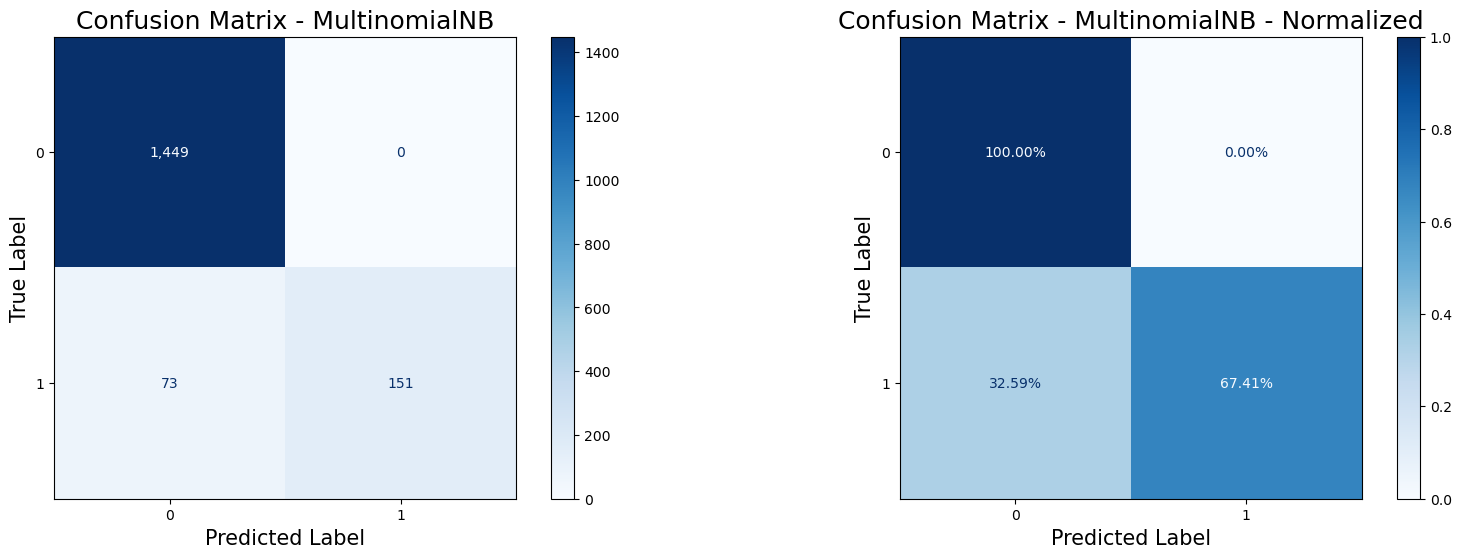

In [13]:
accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - MultinomialNB')

In [14]:
pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictCNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1449
           1       0.95      0.89      0.92       224

    accuracy                           0.98      1673
   macro avg       0.97      0.94      0.95      1673
weighted avg       0.98      0.98      0.98      1673



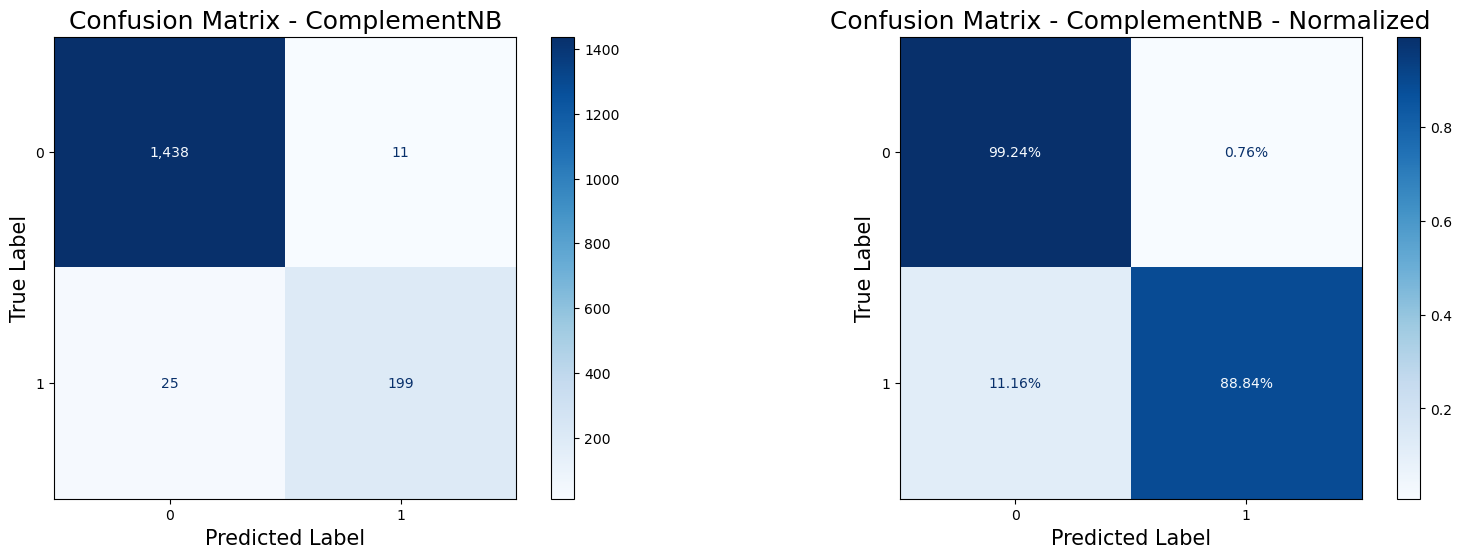

In [15]:
accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - ComplementNB')

In [16]:
pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.97      0.91      0.94       224

    accuracy                           0.98      1673
   macro avg       0.98      0.95      0.96      1673
weighted avg       0.98      0.98      0.98      1673



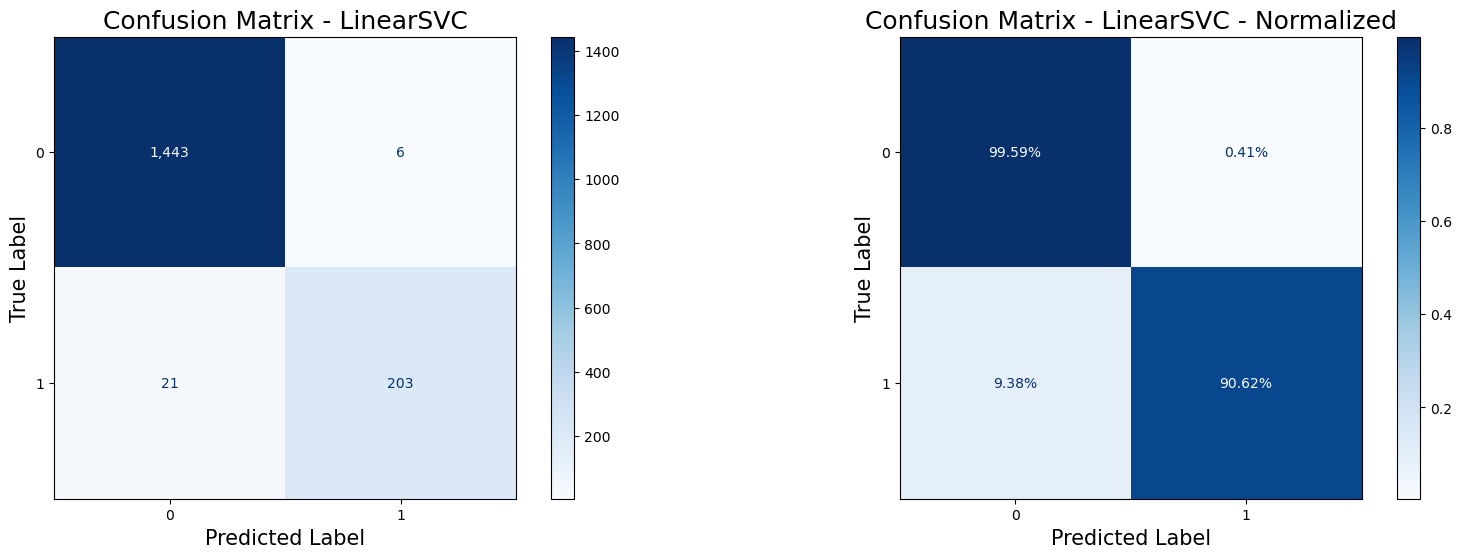

In [17]:
accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - LinearSVC')

### **¿Pasa algo si introducimos el parámetro stop_words?, en este caso en inglés por qué es el idioma de los sms, ¿cambian los resultados?, ¿para mejor o para peor?**

In [18]:
pipeMNB = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),('clf', MultinomialNB())])

pipeCNB = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),('clf', ComplementNB())])

pipeSVC = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),('clf', LinearSVC())])

In [19]:
pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1449
           1       1.00      0.78      0.88       224

    accuracy                           0.97      1673
   macro avg       0.98      0.89      0.93      1673
weighted avg       0.97      0.97      0.97      1673



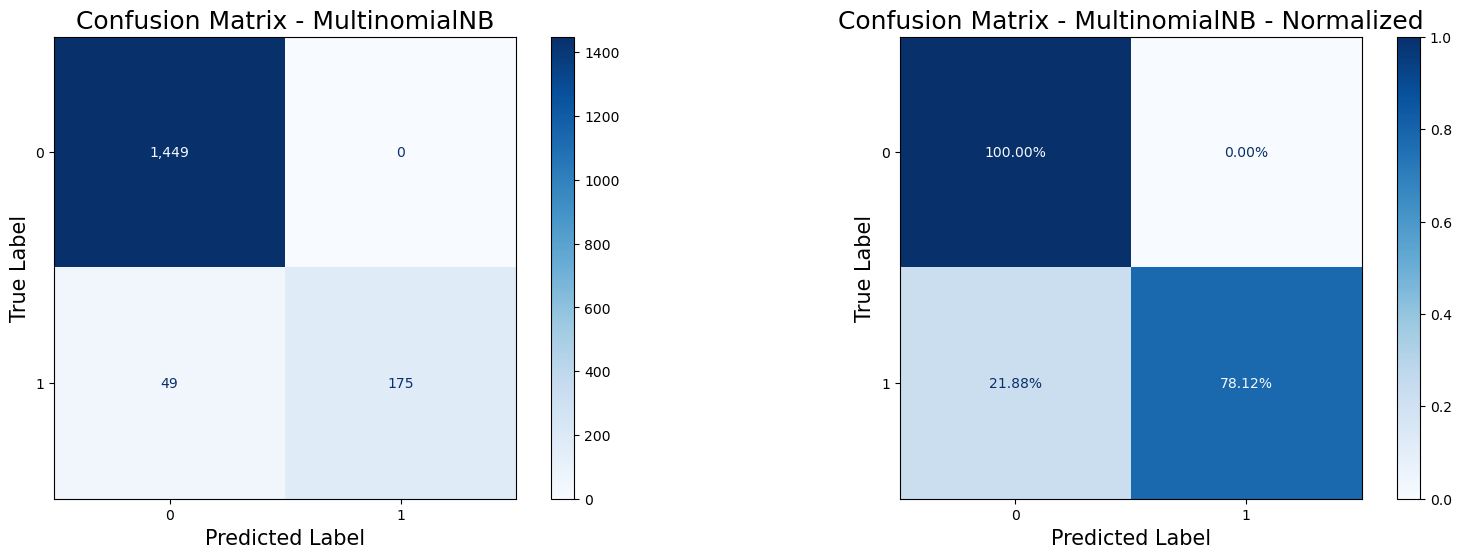

In [20]:
accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - MultinomialNB')

In [21]:
pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictCNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1449
           1       0.81      0.92      0.86       224

    accuracy                           0.96      1673
   macro avg       0.90      0.95      0.92      1673
weighted avg       0.96      0.96      0.96      1673



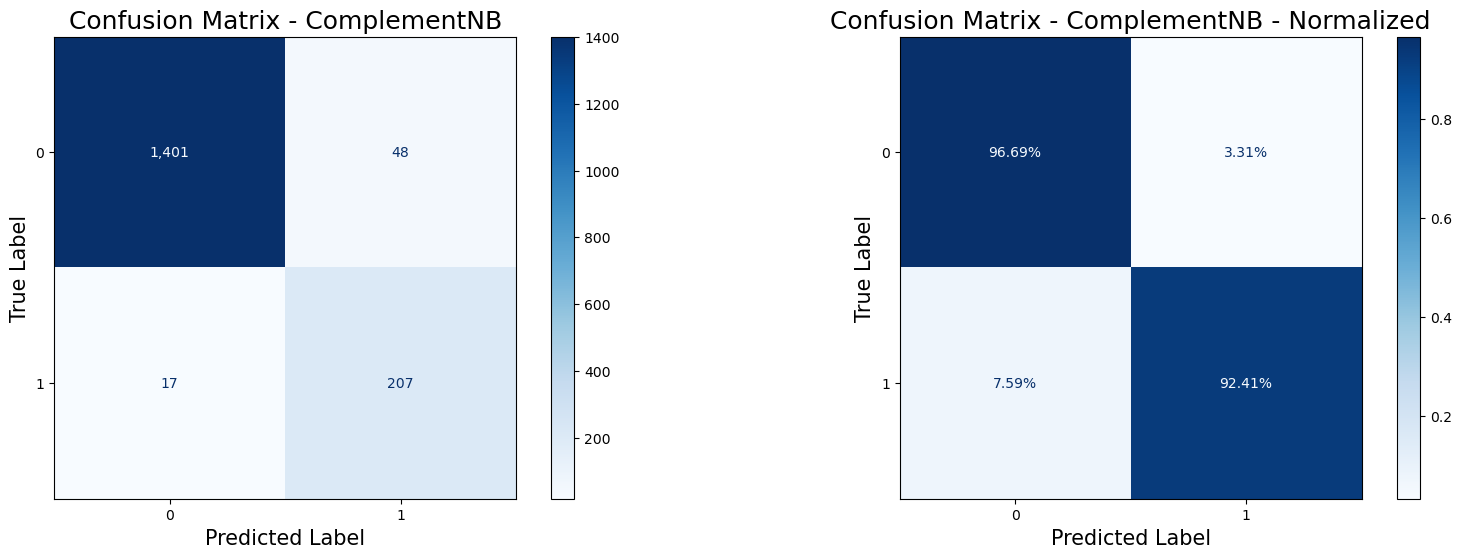

In [22]:
accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - ComplementNB')

In [23]:
pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.98      0.88      0.92       224

    accuracy                           0.98      1673
   macro avg       0.98      0.94      0.96      1673
weighted avg       0.98      0.98      0.98      1673



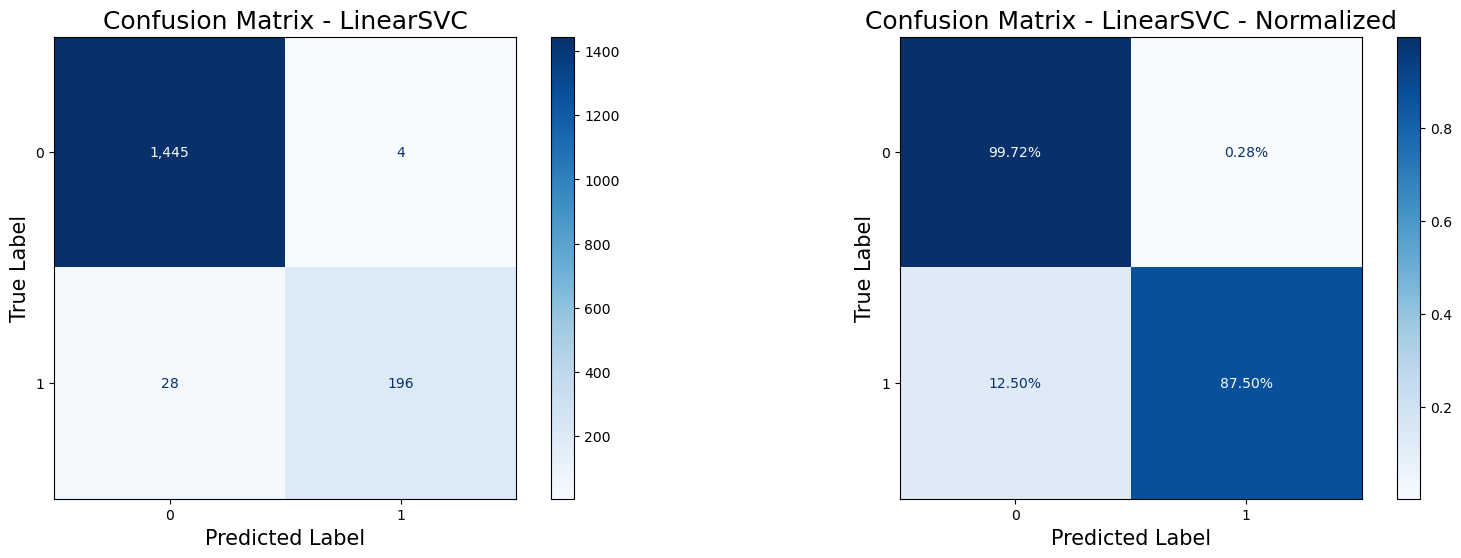

In [24]:
accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - LinearSVC')

A continuación se presentan los resultados obtenidos al evaluar los tres modelos con y sin la eliminación de **stop words** en el preprocesamiento del texto:

###  Sin eliminar *stop words*
-  **MultinomialNB**: 0.96  
-  **ComplementNB**: 0.98  
-  **LinearSVC**: 0.98  

###  Con eliminación de *stop words*
-  **MultinomialNB**: 0.97  
-  **ComplementNB**: 0.96  
-  **LinearSVC**: 0.98  

 Observaciones:
- El modelo **LinearSVC** mantiene una precisión constante y alta en ambos escenarios.
- **MultinomialNB** mejora ligeramente al eliminar *stop words*.
- Por el contrario, **ComplementNB** sufre una leve caída en rendimiento con la eliminación de *stop words*.


A priori, basandonos en el accuracy, parece que pueda haber empeorado, pero fijandonos en la matriz de confusión, los modelos de predicción de MultinomialNB y ComplementNB mejoran mucho el resultado en cuanto a los mensajes de SPAM clasificados correctamente. Por otro lado el modelo de LinearSVC, pese a mantener el mismo puntaje de accuracy, ha perdido capacidad de clasificación de mensajes de spam pasando de clasificar incorrectamente 21 mensajes a 28. 

### ¿Y si en vez de eso aplicamos el parámetro ***n_grams***?

El ***n_grams*** parámetro define el rango de n-gramas que se deben considerar al transformar el texto en una representación numérica.

In [25]:
pipeMNB = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3))),('clf', MultinomialNB())])

pipeCNB = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3))),('clf', ComplementNB())])

pipeSVC = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3))),('clf', LinearSVC())])

In [26]:
pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1449
           1       1.00      0.50      0.67       224

    accuracy                           0.93      1673
   macro avg       0.96      0.75      0.82      1673
weighted avg       0.94      0.93      0.92      1673



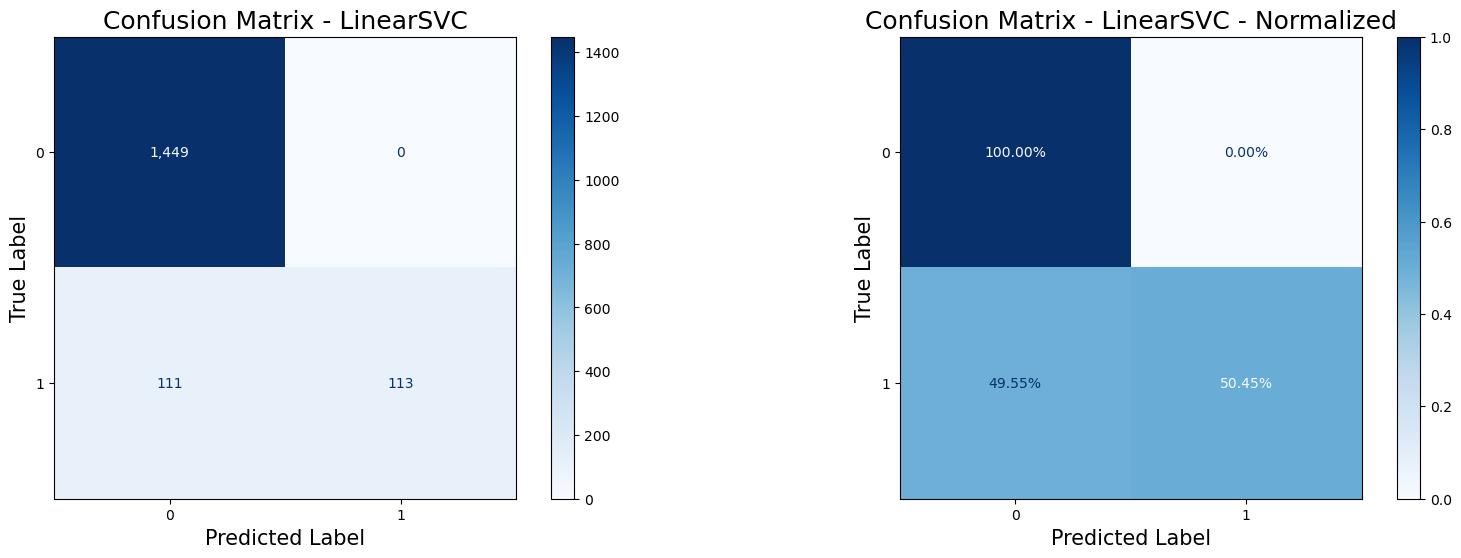

In [27]:
accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - LinearSVC')

In [28]:
pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictCNB

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1449
           1       0.99      0.81      0.89       224

    accuracy                           0.97      1673
   macro avg       0.98      0.91      0.94      1673
weighted avg       0.97      0.97      0.97      1673



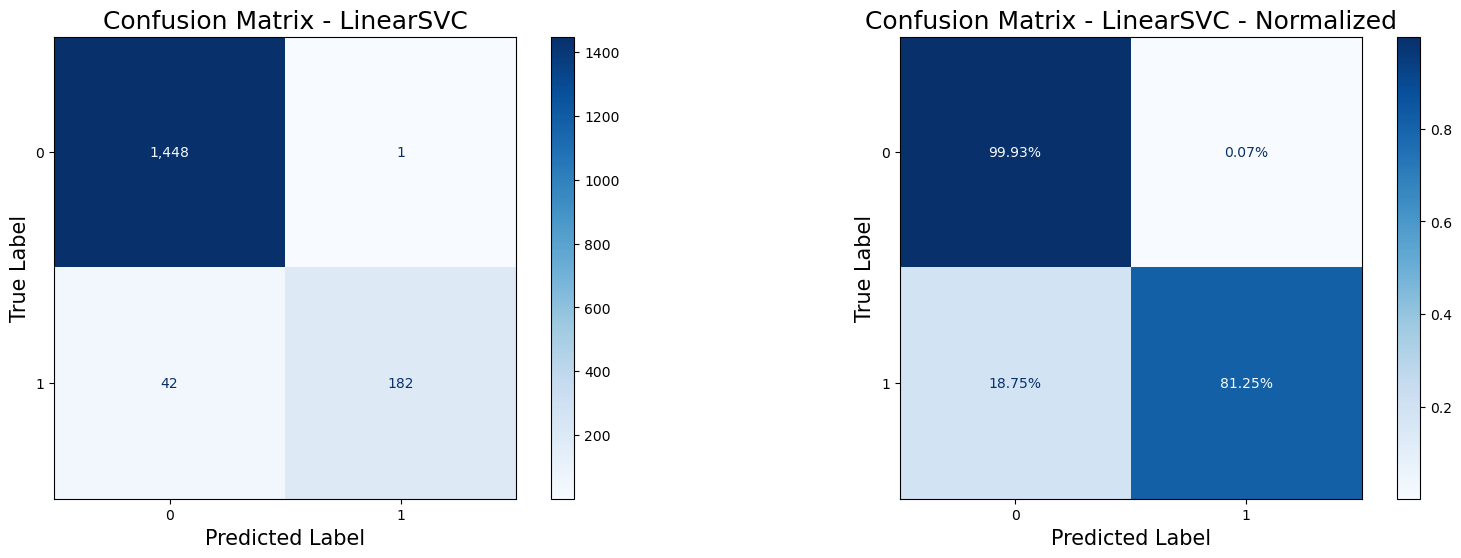

In [29]:
accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - LinearSVC')

In [30]:
pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

array([0, 0, 1, ..., 1, 0, 0])

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.97      0.92      0.94       224

    accuracy                           0.99      1673
   macro avg       0.98      0.96      0.97      1673
weighted avg       0.99      0.99      0.99      1673



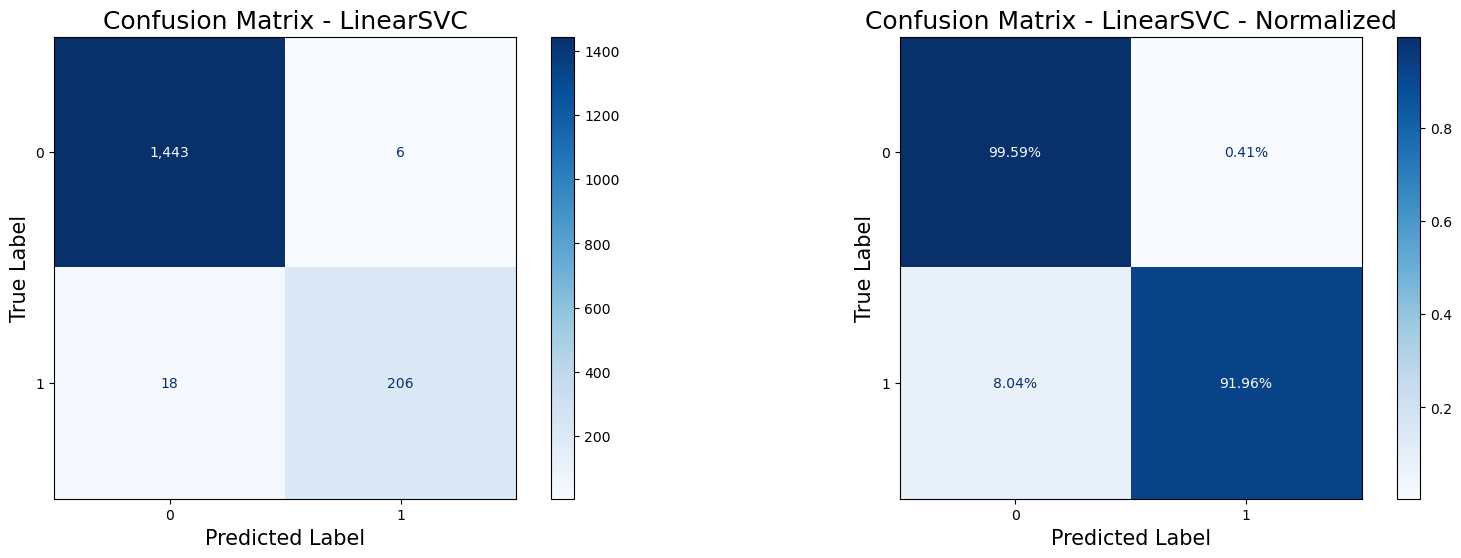

In [31]:
accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - LinearSVC')

### **Parece que este parámetro solo afecta de manera positiva al modelo de LinearSVC. Mejorando su accuracy hasta el 99%. Probemos ahora ambos parámetros**

In [32]:
pipeMNB = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',ngram_range=(1,3))),('clf', MultinomialNB())])

pipeCNB = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',ngram_range=(1,3))),('clf', ComplementNB())])

pipeSVC = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',ngram_range=(1,3))),('clf', LinearSVC())])

In [33]:
pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictCNB

pipeSVC.fit(X_train, y_train)
predictSVC = pipeMNB.predict(X_test)
predictSVC

array([0, 0, 1, ..., 1, 0, 0])

### **Poniendolo en práctica:**

In [34]:
msg_1 = "Congrats for your new job in CUNEF" # SMS normal
msg_2 = "You have been selected for a new Apple Device throught our website. Click here to claim your prize!" #Spam
msg_3 = "Hi Juan, how r u? I need to tlk with u. Pls call me asap. Thx" #SMS normal
msg_4 = "you ve won a $1000 prize! contact us and claim it asap!" #Spam
msg_5 = "someone from CUENF is trying to contact you. Please call us back at 555-1234" #Spam/Phising
msg_6 = "hello, Im Ahmed, prince of Nigeria, and I want to share with you a great opportunity to make money. Please send me your bank account number to share the details" #Spam
msg_7 = "Hey, do you want to hang out this weekend? Let me know when you're free!"  # SMS normal
msg_8 = "Congratulations! You've been selected to receive a free iPhone! Click here to claim it!"  # Spam
msg_9 = "Hi there, just checking in to see if you're available for a call later today."  # SMS normal
msg_10 = "You've been chosen to win a $5000 gift card! Claim it now before it's too late!"  # Spam
msg_11 = "Urgent: You have a limited time to claim your free vacation package! Call now!"  # Spam
msg_12 = "Win a free iPad now! Just respond to this message with 'YES' and you’re in!"  # Spam

messages = [msg_1, msg_2, msg_3, msg_4, msg_5, msg_6, msg_7, msg_8, msg_9, msg_10, msg_11, msg_12]


In [35]:
print(pipeMNB.predict(messages))
print(pipeCNB.predict(messages))
print(pipeSVC.predict(messages))

[0 0 0 1 0 0 0 0 0 0 0 0]
[0 1 0 1 1 0 0 1 0 1 1 0]
[0 1 0 1 0 0 0 1 0 1 1 1]


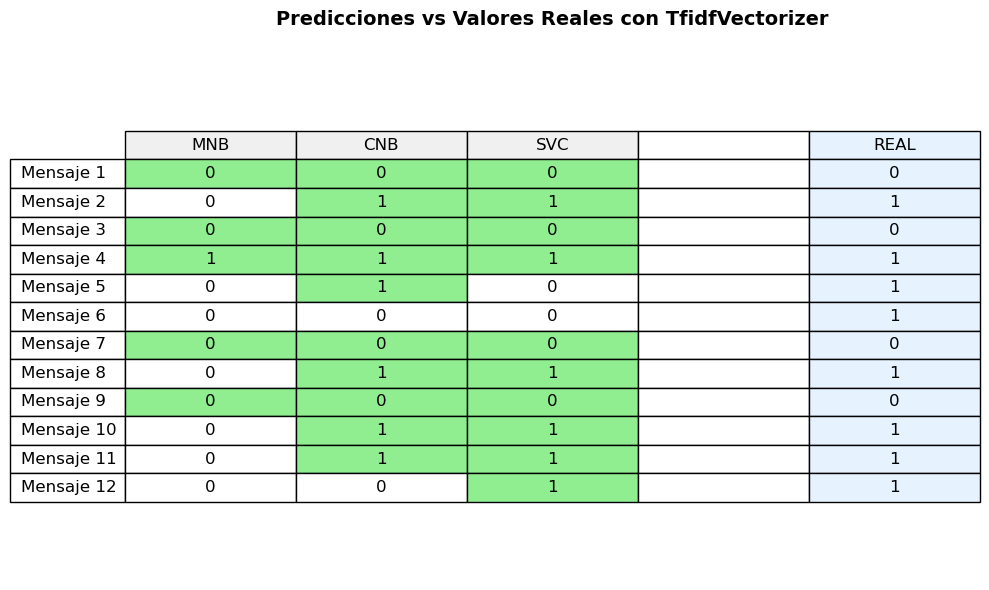

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Datos
mnb_pred = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
cnb_pred = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
svc_pred = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
real = [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]

# DataFrame con columna REAL
df = pd.DataFrame({
    'MNB': mnb_pred,
    'CNB': cnb_pred,
    'SVC': svc_pred,
    'REAL': real
}, index=[f'Mensaje {i+1}' for i in range(12)])

# Configuración de la figura
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.axis('off')

# Crear tabla con columna adicional
table = plt.table(
    cellText=np.hstack([df[['MNB', 'CNB', 'SVC']].values, np.full((12,1), ''), df[['REAL']].values]),
    rowLabels=df.index,
    colLabels=['MNB', 'CNB', 'SVC', '', 'REAL'],  # Columna vacía como separador
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0']*3 + ['white'] + ['#e6f3ff']  # Colores de fondo
)

# Colorear coincidencias
for row in range(12):
    for col, model in enumerate(['MNB', 'CNB', 'SVC']):
        if df.iloc[row][model] == df.iloc[row]['REAL']:
            table[row+1, col].set_facecolor('#90EE90')  # Verde claro para coincidencias
    table[row+1, 4].set_facecolor('#e6f3ff')  # Fondo azul claro para columna REAL

# Formateo adicional
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
plt.title("Predicciones vs Valores Reales con TfidfVectorizer", fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

-------------------------------------------------------------------
# **ADICIONAL**

**A partir de este punto, lo siguiente fue propuesto por el docente para dar más profundidad al trabajo**

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.98      0.92      0.95       224

    accuracy                           0.99      1673
   macro avg       0.98      0.96      0.97      1673
weighted avg       0.99      0.99      0.99      1673



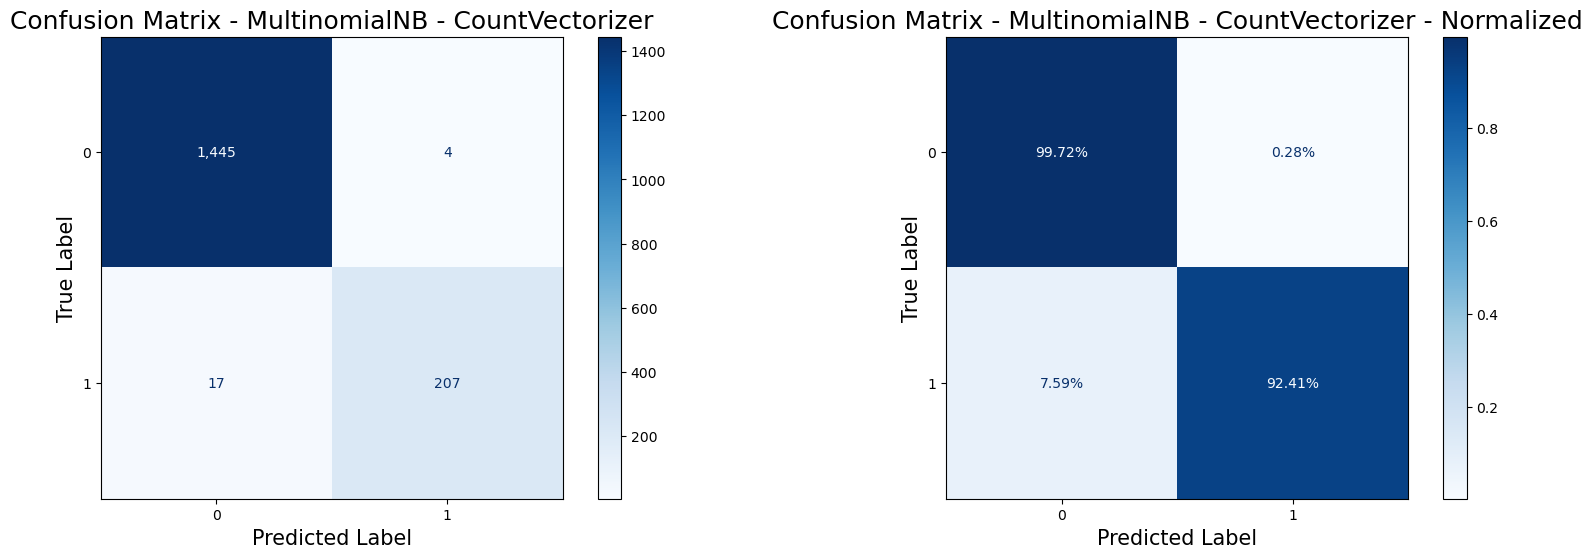

In [37]:
pipeMNB = Pipeline([
    ('countvect', CountVectorizer()),
    ('clf', MultinomialNB())
])

pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - MultinomialNB - CountVectorizer')

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1449
           1       0.90      0.94      0.92       224

    accuracy                           0.98      1673
   macro avg       0.94      0.96      0.95      1673
weighted avg       0.98      0.98      0.98      1673



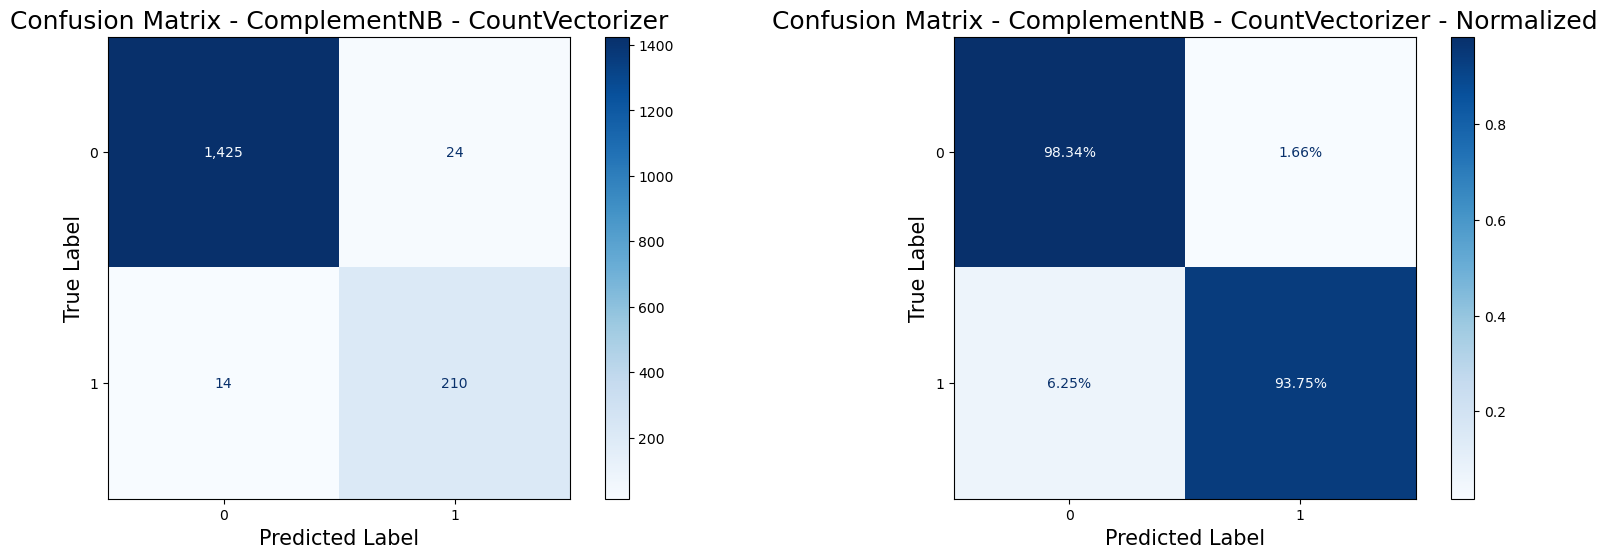

In [38]:
pipeCNB = Pipeline([
    ('countvect', CountVectorizer()),
    ('clf', ComplementNB())
])

pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - ComplementNB - CountVectorizer')

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1449
           1       0.90      0.94      0.92       224

    accuracy                           0.98      1673
   macro avg       0.94      0.96      0.95      1673
weighted avg       0.98      0.98      0.98      1673



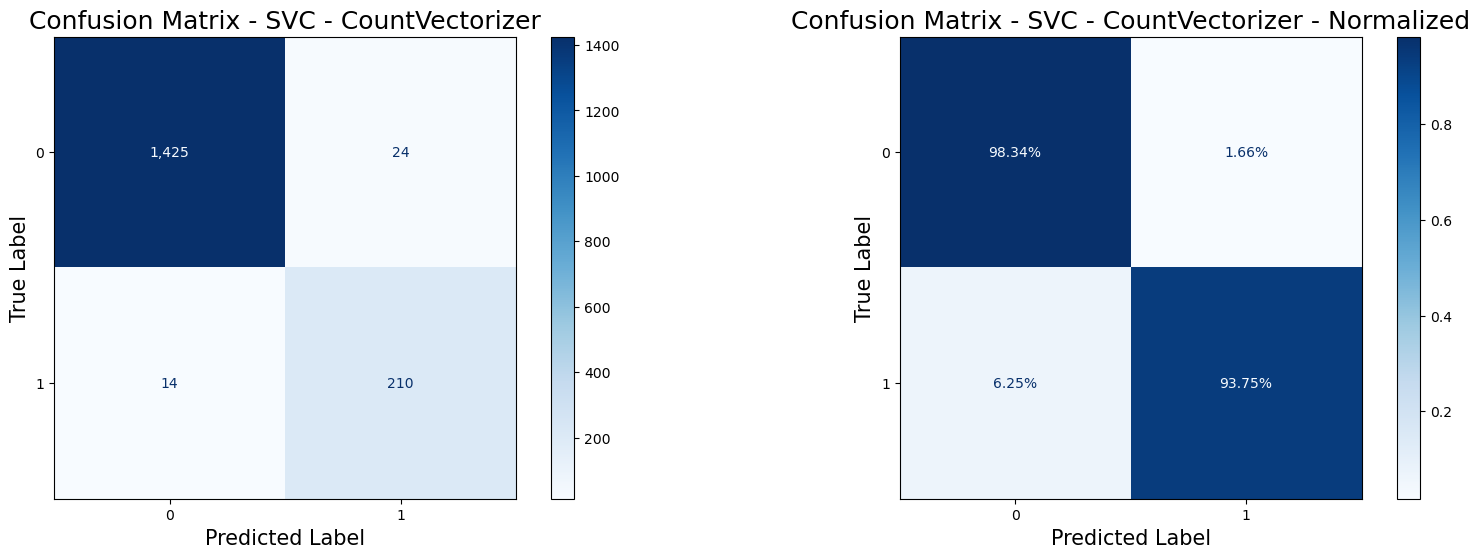

In [39]:
pipeSVC = Pipeline([
    ('countvect', CountVectorizer()),
    ('clf', ComplementNB())
])

pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - SVC - CountVectorizer')

### **Al igual que antes, aplicamos también stop_words para ver si mejora la capacidad de discriminación**

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.97      0.93      0.95       224

    accuracy                           0.99      1673
   macro avg       0.98      0.96      0.97      1673
weighted avg       0.99      0.99      0.99      1673



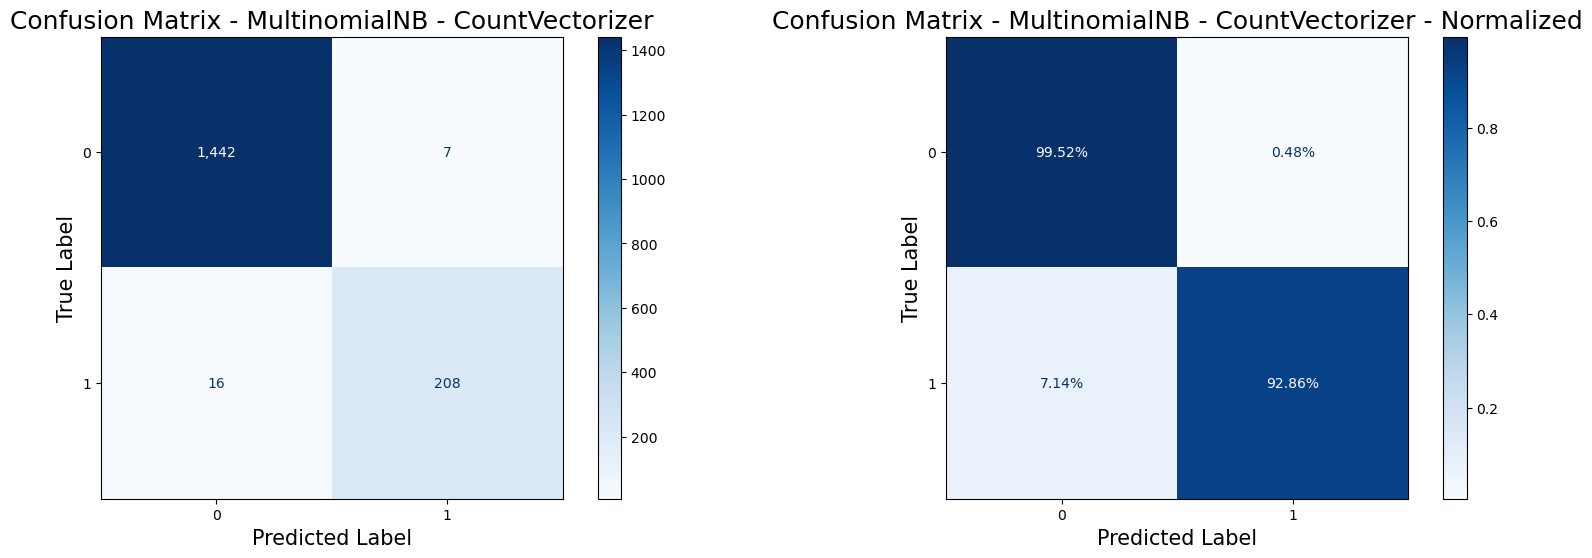

In [40]:
pipeMNB = Pipeline([
    ('countvect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - MultinomialNB - CountVectorizer')

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1449
           1       0.77      0.95      0.85       224

    accuracy                           0.95      1673
   macro avg       0.88      0.95      0.91      1673
weighted avg       0.96      0.95      0.96      1673



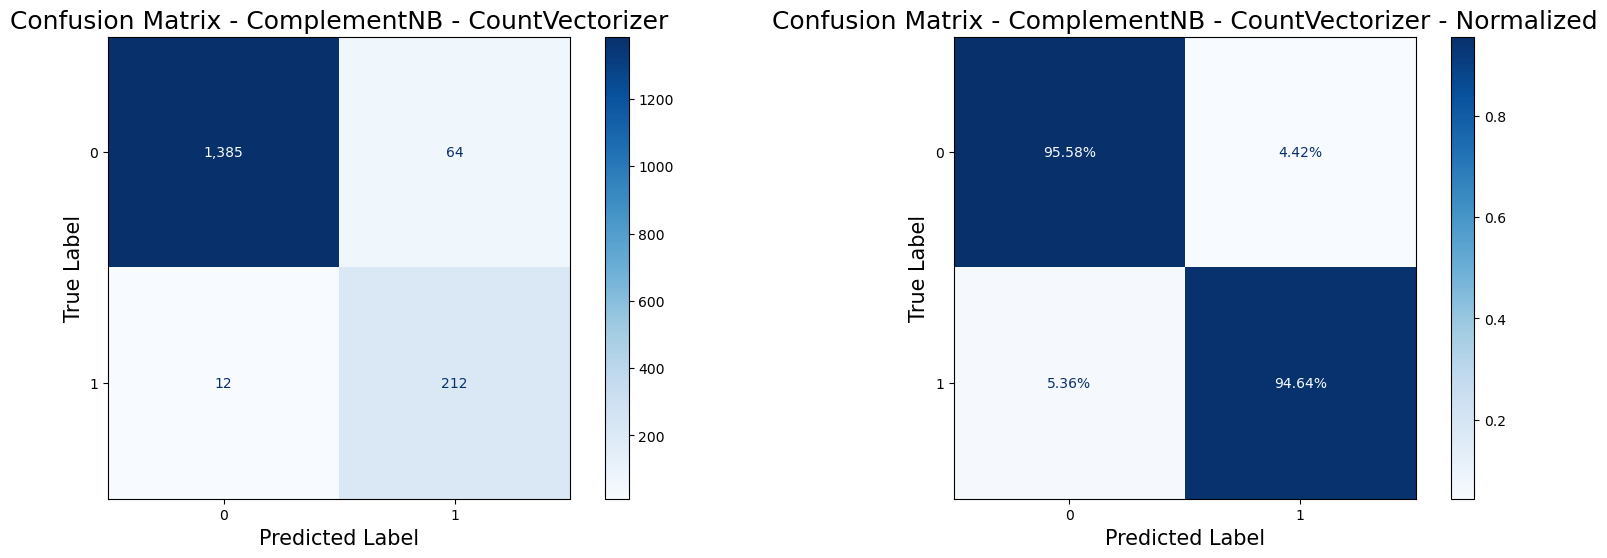

In [41]:
pipeCNB = Pipeline([
    ('countvect', CountVectorizer(stop_words='english')), 
    ('clf', ComplementNB())
])

pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - ComplementNB - CountVectorizer')

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.99      0.86      0.92       224

    accuracy                           0.98      1673
   macro avg       0.99      0.93      0.95      1673
weighted avg       0.98      0.98      0.98      1673



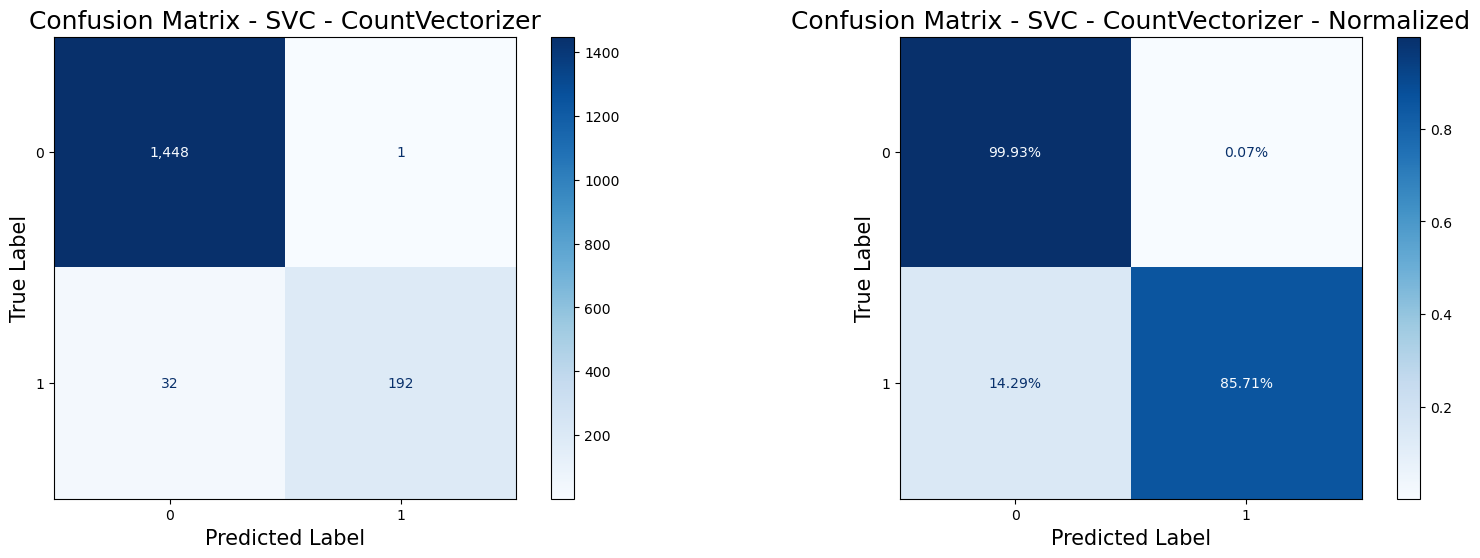

In [42]:
pipeSVC = Pipeline([
    ('countvect', CountVectorizer(stop_words='english')),  
    ('clf', LinearSVC())
])

pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - SVC - CountVectorizer')

### **Lo mismo con n_grams al igual que con TFIDF**

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.99      0.89      0.94       224

    accuracy                           0.98      1673
   macro avg       0.99      0.95      0.97      1673
weighted avg       0.98      0.98      0.98      1673



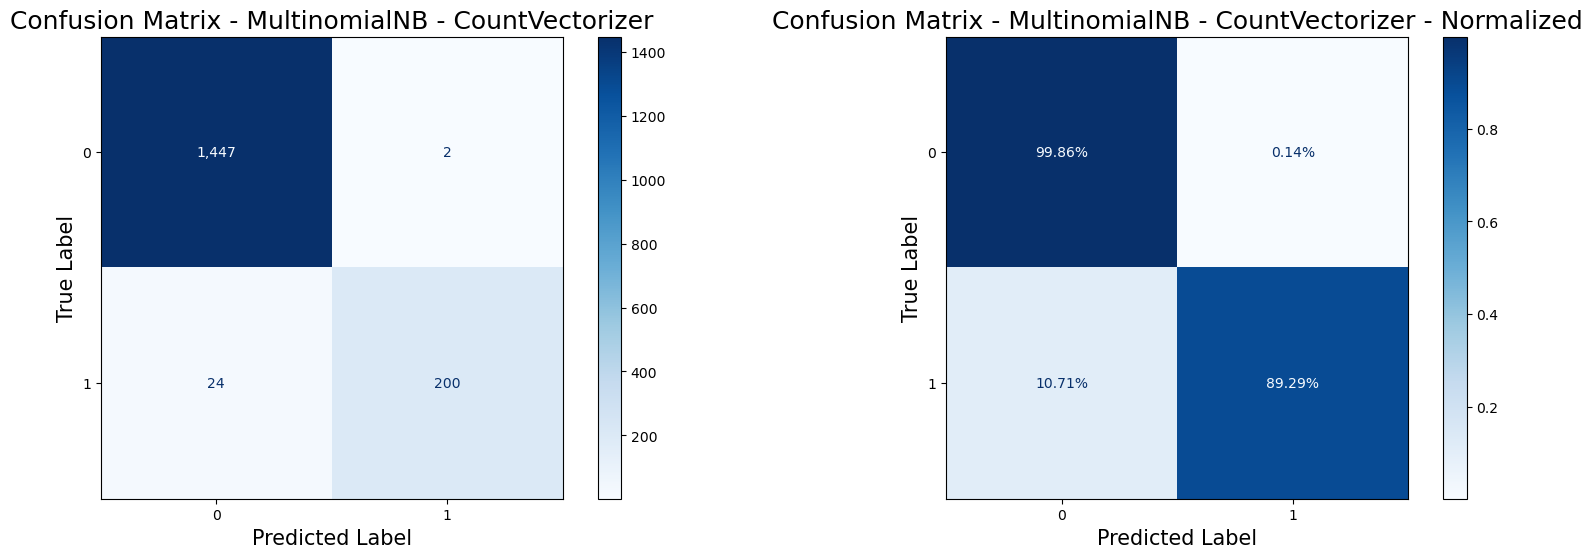

In [43]:
pipeMNB = Pipeline([
    ('countvect', CountVectorizer(ngram_range=(1,3))),  
    ('clf', MultinomialNB())
])

pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictMNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictMNB))

conf_matrix = confusion_matrix(y_test, predictMNB)
plot_confusion_matrix(y_test, predictMNB, title='Confusion Matrix - MultinomialNB - CountVectorizer')

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.97      0.90      0.93       224

    accuracy                           0.98      1673
   macro avg       0.98      0.95      0.96      1673
weighted avg       0.98      0.98      0.98      1673



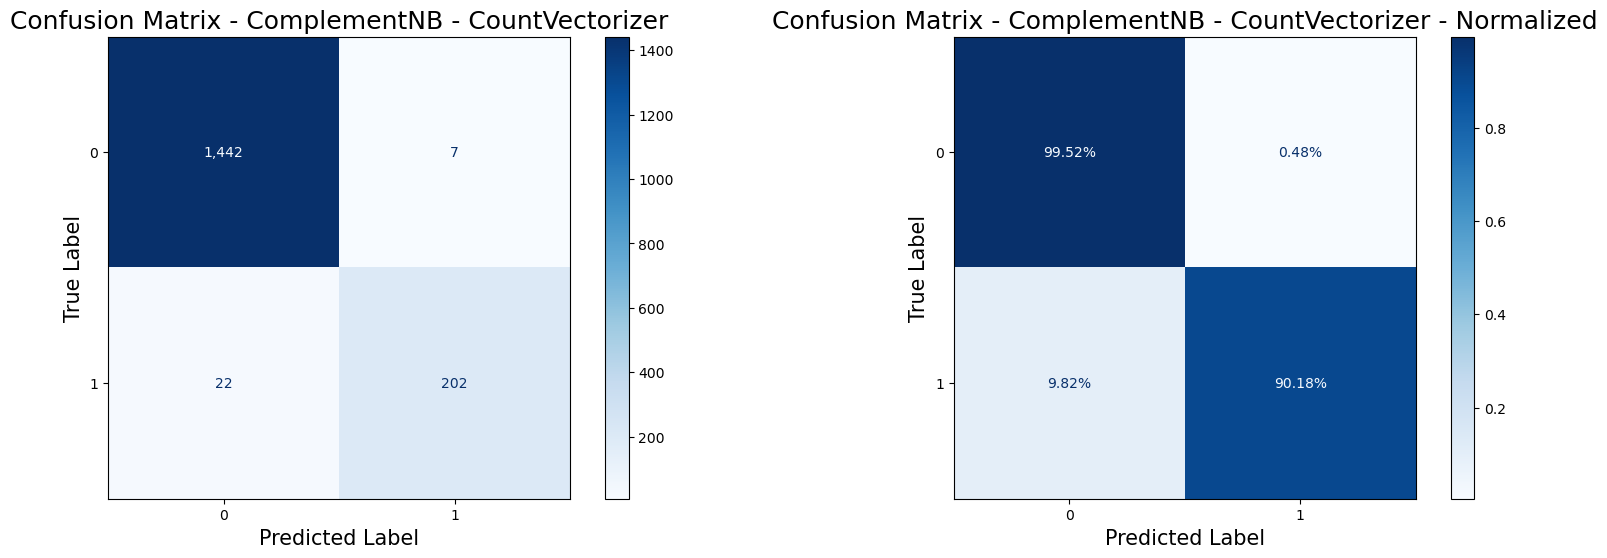

In [44]:
pipeCNB = Pipeline([
    ('countvect', CountVectorizer(ngram_range=(1,3))),  
    ('clf', ComplementNB())
])

pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictMNB

accuracy = accuracy_score(y_test, predictCNB)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictCNB))

conf_matrix = confusion_matrix(y_test, predictCNB)
plot_confusion_matrix(y_test, predictCNB, title='Confusion Matrix - ComplementNB - CountVectorizer')

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1449
           1       0.99      0.85      0.91       224

    accuracy                           0.98      1673
   macro avg       0.98      0.92      0.95      1673
weighted avg       0.98      0.98      0.98      1673



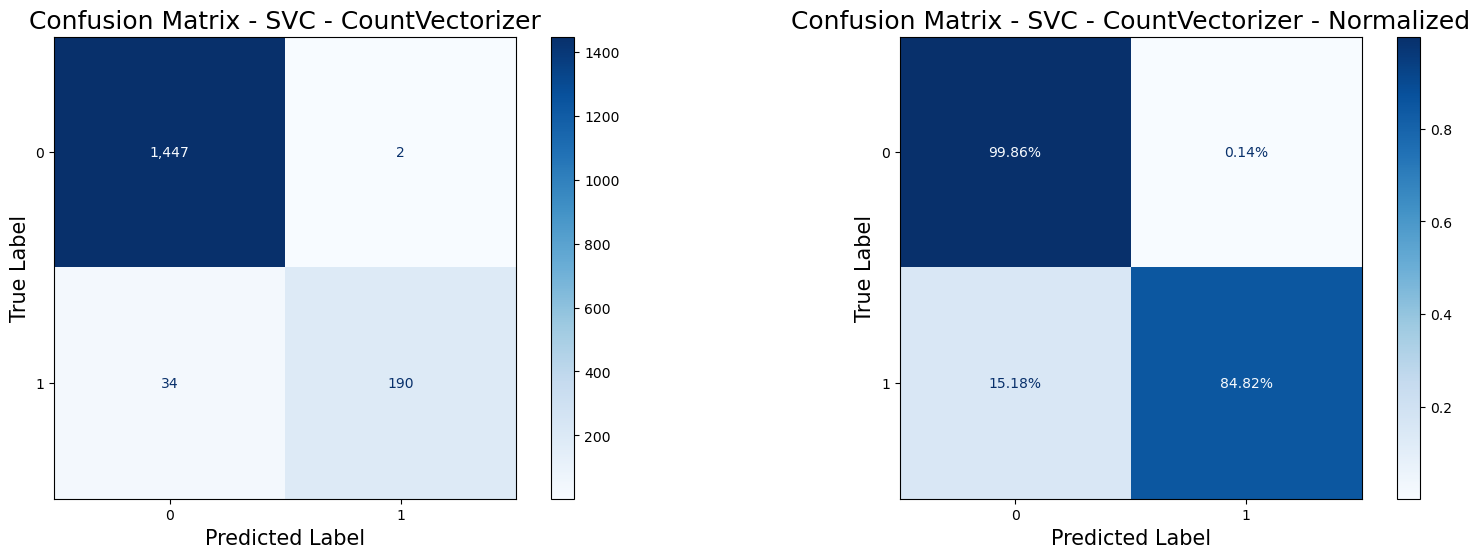

In [45]:
pipeSVC = Pipeline([
    ('countvect', CountVectorizer(ngram_range=(1,3))),  
    ('clf', LinearSVC())
])

pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

accuracy = accuracy_score(y_test, predictSVC)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, predictSVC))

conf_matrix = confusion_matrix(y_test, predictSVC)
plot_confusion_matrix(y_test, predictSVC, title='Confusion Matrix - SVC - CountVectorizer')

### **Parece que, estos parámetros en concreto, no se mejora respecto a no incluir parámetros, es decir, como se hace en el primer análisis de este apartado, así que lo utilizaremos para ver si discrimina mejor que TFIDF**

In [46]:
pipeMNB = Pipeline([
    ('countvect', CountVectorizer()),
    ('clf', MultinomialNB())
])

pipeMNB.fit(X_train, y_train)
predictMNB = pipeMNB.predict(X_test)
predictMNB

pipeCNB = Pipeline([
    ('countvect', CountVectorizer()),  
    ('clf', ComplementNB())
])

pipeCNB.fit(X_train, y_train)
predictCNB = pipeCNB.predict(X_test)
predictMNB

pipeSVC = Pipeline([
    ('countvect', CountVectorizer()),  
    ('clf', LinearSVC())
])

pipeSVC.fit(X_train, y_train)
predictSVC = pipeSVC.predict(X_test)
predictSVC

array([0, 0, 1, ..., 1, 0, 0])

In [47]:
msg_1 = "Congrats for your new job in CUNEF" # SMS normal
msg_2 = "You have been selected for a new Apple Device throught our website. Click here to claim your prize!" #Spam
msg_3 = "Hi Juan, how r u? I need to tlk with u. Pls call me asap. Thx" #SMS normal
msg_4 = "you ve won a $1000 prize! contact us and claim it asap!" #Spam
msg_5 = "someone from CUENF is trying to contact you. Please call us back at 555-1234" #Spam/Phising
msg_6 = "hello, Im Ahmed, prince of Nigeria, and I want to share with you a great opportunity to make money. Please send me your bank account number to share the details" #Spam
msg_7 = "Hey, do you want to hang out this weekend? Let me know when you're free!"  # SMS normal
msg_8 = "Congratulations! You've been selected to receive a free iPhone! Click here to claim it!"  # Spam
msg_9 = "Hi there, just checking in to see if you're available for a call later today."  # SMS normal
msg_10 = "You've been chosen to win a $5000 gift card! Claim it now before it's too late!"  # Spam
msg_11 = "Urgent: You have a limited time to claim your free vacation package! Call now!"  # Spam
msg_12 = "Win a free iPad now! Just respond to this message with 'YES' and you’re in!"  # Spam

messages = [msg_1, msg_2, msg_3, msg_4, msg_5, msg_6, msg_7, msg_8, msg_9, msg_10, msg_11, msg_12]

In [48]:
print(pipeMNB.predict(messages))
print(pipeCNB.predict(messages))
print(pipeSVC.predict(messages))

[0 1 0 1 0 0 0 1 0 1 1 0]
[0 1 0 1 1 0 0 1 0 1 1 1]
[0 1 0 1 0 0 0 1 0 0 1 1]


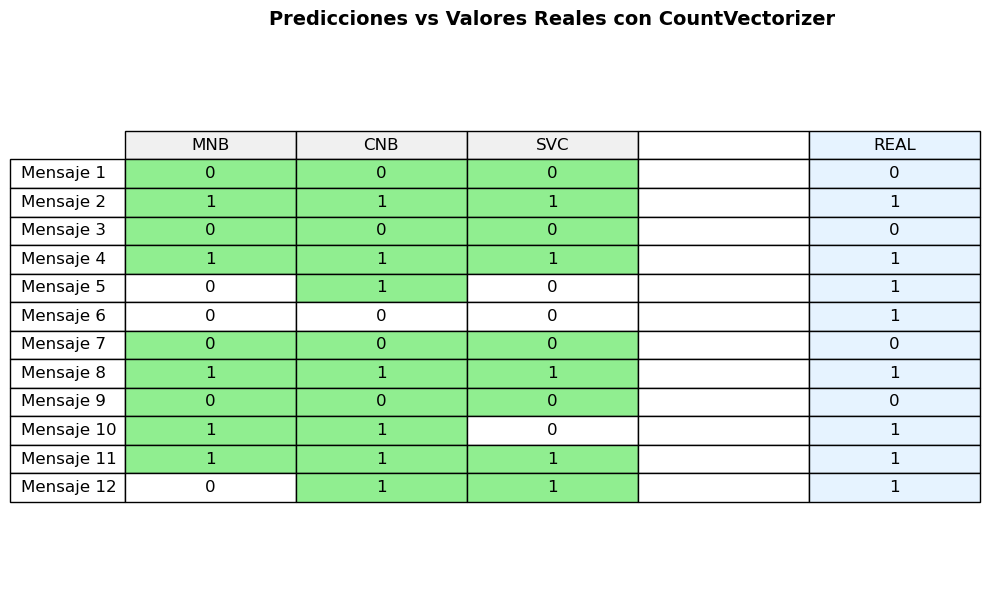

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Datos
mnb_pred = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
cnb_pred = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
svc_pred = [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
real = [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]

# **REAL: [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]**

# DataFrame con columna REAL
df = pd.DataFrame({
    'MNB': mnb_pred,
    'CNB': cnb_pred,
    'SVC': svc_pred,
    'REAL': real
}, index=[f'Mensaje {i+1}' for i in range(12)])

# Configuración de la figura
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.axis('off')

# Crear tabla con columna adicional
table = plt.table(
    cellText=np.hstack([df[['MNB', 'CNB', 'SVC']].values, np.full((12,1), ''), df[['REAL']].values]),
    rowLabels=df.index,
    colLabels=['MNB', 'CNB', 'SVC', '', 'REAL'],  # Columna vacía como separador
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0']*3 + ['white'] + ['#e6f3ff']  # Colores de fondo
)

# Colorear coincidencias
for row in range(12):
    for col, model in enumerate(['MNB', 'CNB', 'SVC']):
        if df.iloc[row][model] == df.iloc[row]['REAL']:
            table[row+1, col].set_facecolor('#90EE90')  # Verde claro para coincidencias
    table[row+1, 4].set_facecolor('#e6f3ff')  # Fondo azul claro para columna REAL

# Formateo adicional
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
plt.title("Predicciones vs Valores Reales con CountVectorizer", fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

### **¿Y si también se prueba la regresión logística?**

In [50]:
pipeLR = Pipeline([
    ('countvect', CountVectorizer(
        stop_words="english",
        max_features=5000,
        ngram_range=(1, 2)
    )),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        random_state=seed,
        max_iter=2000,
        class_weight='balanced'
    ))
])

param_grid = {
    'countvect__max_features': [3000, 5000],  
    'countvect__ngram_range': [(1, 2)],       
    'clf__C': [0.1, 1],                       
    'clf__l1_ratio': [0.5],                   
    'clf__tol': [1e-3]                        
}

grid_search = GridSearchCV(
    estimator=pipeLR,
    param_grid=param_grid,
    cv=3,                         
    scoring='accuracy',           
    n_jobs=-1,                     
    verbose=3                      
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

predictLR = best_model.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [51]:
predictions = best_model.predict(messages)
print(predictions)

[0 1 0 1 0 0 0 1 0 1 1 1]


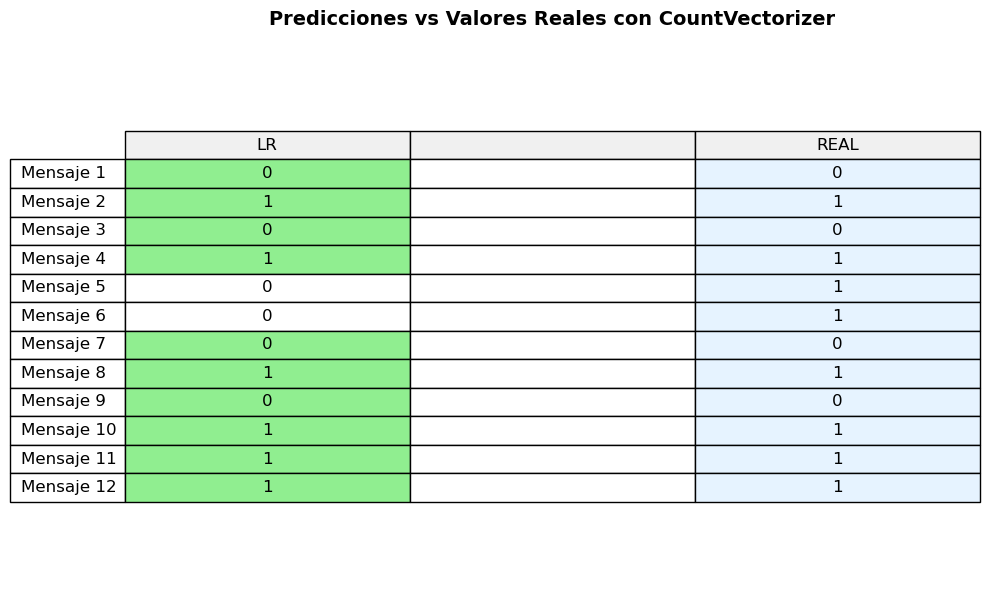

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

lr_pred = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]

df = pd.DataFrame({
    'LR': lr_pred,
    'REAL': real
}, index=[f'Mensaje {i+1}' for i in range(12)])

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.axis('off')

table = plt.table(
    cellText=np.hstack([df[['LR']].values, np.full((12,1), ''), df[['REAL']].values]),
    rowLabels=df.index,
    colLabels=[ 'LR', '', 'REAL'],  
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0']*3 + ['white'] + ['#e6f3ff']  
)

# Colorear coincidencias
for row in range(12):
    for col, model in enumerate([ 'LR']):
        if df.iloc[row][model] == df.iloc[row]['REAL']:
            table[row+1, col].set_facecolor('#90EE90') 
    table[row+1, 2].set_facecolor('#e6f3ff') 

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
plt.title("Predicciones vs Valores Reales con CountVectorizer", fontsize=14, pad=20, weight='bold')
plt.tight_layout()
plt.show()

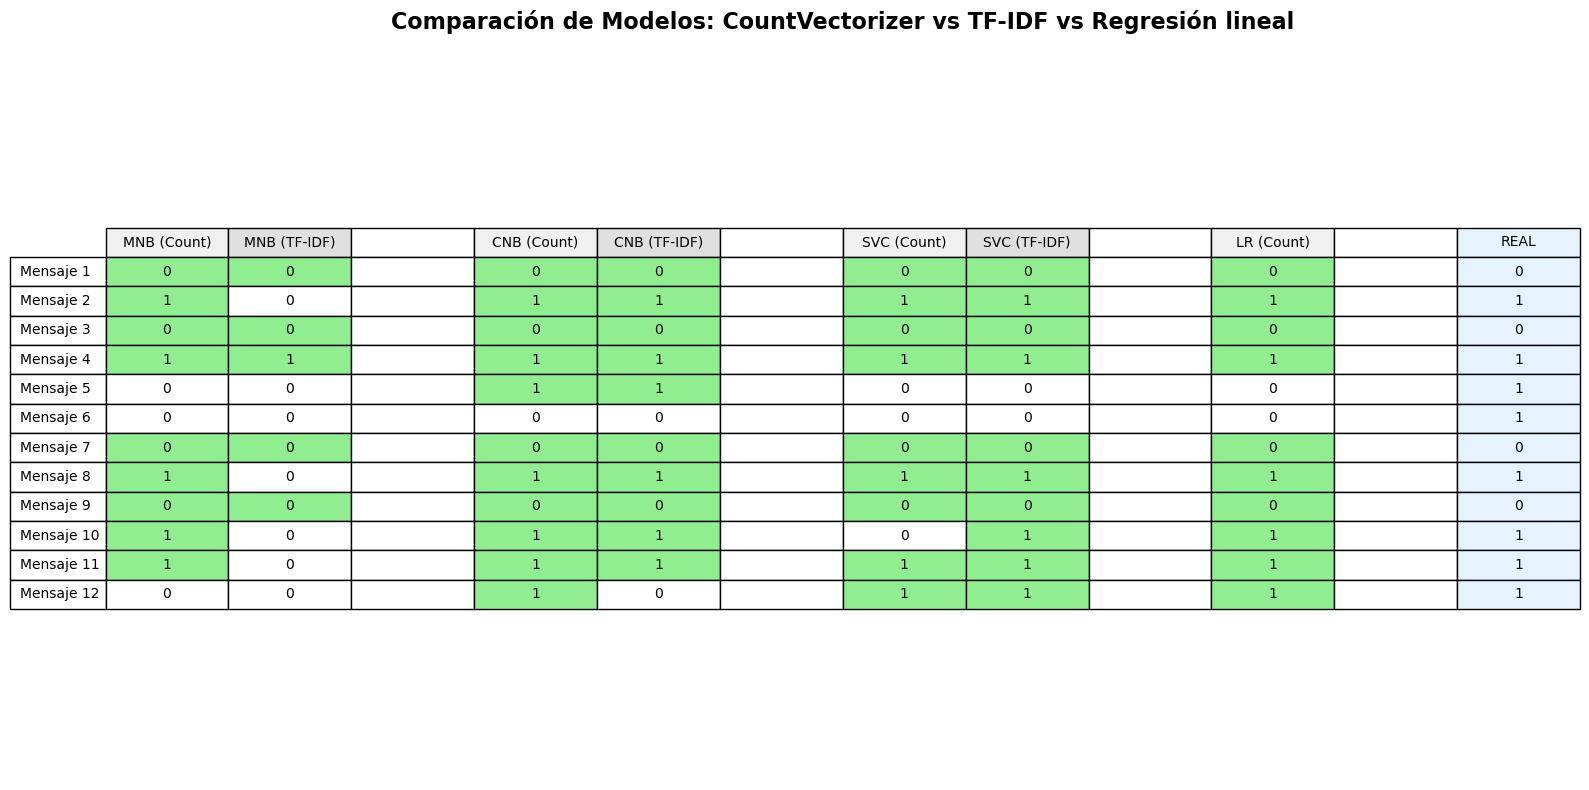

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

mnb_tfidf = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
cnb_tfidf = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
svc_tfidf = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1] 

mnb_count = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
cnb_count = [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
svc_count = [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]

lr_count = [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]

real = [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]

df = pd.DataFrame({
    'MNB (Count)': mnb_count,
    'MNB (TF-IDF)': mnb_tfidf,
    'CNB (Count)': cnb_count,
    'CNB (TF-IDF)': cnb_tfidf,
    'SVC (Count)': svc_count,
    'SVC (TF-IDF)': svc_tfidf,
    'LR (Count)': lr_count,
    'REAL': real
}, index=[f'Mensaje {i+1}' for i in range(12)])

plt.figure(figsize=(16, 8))
ax = plt.gca()
ax.axis('off')

table_data = np.hstack([
    df[['MNB (Count)', 'MNB (TF-IDF)']].values.astype(object),  # Mantener como objetos
    np.full((12, 1), None),  # Usar None en lugar de ''
    df[['CNB (Count)', 'CNB (TF-IDF)']].values.astype(object),
    np.full((12, 1), None),
    df[['SVC (Count)', 'SVC (TF-IDF)']].values.astype(object),
    np.full((12, 1), None),
    df[['LR (Count)']].values.astype(object),
    np.full((12, 1), None),
    df[['REAL']].values.astype(object)
])

col_labels = [
    'MNB (Count)', 'MNB (TF-IDF)', '',
    'CNB (Count)', 'CNB (TF-IDF)', '',
    'SVC (Count)', 'SVC (TF-IDF)', '',
    'LR (Count)', '', 'REAL'
]

col_colors = ['#f0f0f0', '#e0e0e0', 'white'] * 3 + ['#f0f0f0', 'white', '#e6f3ff']

table = plt.table(
    cellText=table_data,
    rowLabels=df.index,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    colColours=col_colors
)

for row in range(12):
    for col in range(len(col_labels)):
        if col in [0, 1, 3, 4, 6, 7, 9]:
            cell_value = table_data[row, col]
            if cell_value is not None and int(cell_value) == df.iloc[row]['REAL']:  # Conversión a entero
                table[row+1, col].set_facecolor('#90EE90')
    table[row+1, 11].set_facecolor('#e6f3ff')
    
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title("Comparación de Modelos: CountVectorizer vs TF-IDF vs Regresión lineal", fontsize=16, pad=20, weight='bold')
plt.tight_layout()
plt.show()

# **Conclusiones**

## Comparación de Predicciones por Modelo

A continuación se presenta una comparación entre los valores reales y las predicciones realizadas por distintos modelos, utilizando dos enfoques de vectorización: **TF-IDF** y **CountVectorizer**. Los modelos evaluados son: `MultinomialNB`, `ComplementNB`, `LinearSVC`, y `LinearRegression` (este último incluido a modo de comparación, aunque no es un clasificador puro).

### Valores reales

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]


### Análisis de Resultados

- **ComplementNB con CountVectorizer** obtiene el mejor rendimiento, con 11 aciertos sobre 12.
- **LinearSVC** y **LinearRegression** tienen un desempeño consistente con 10 aciertos cada uno.
- **MultinomialNB** mejora al usar CountVectorizer, pero queda levemente por debajo.
- **TF-IDF**, en general, ofrece peores resultados que CountVectorizer en esta muestra concreta.

### Conclusión

En esta evaluación, **ComplementNB con CountVectorizer** demuestra ser el modelo más efectivo. Sin embargo, **LinearSVC** mantiene un rendimiento estable y competitivo, lo que lo convierte en una opción sólida para aplicaciones reales. La elección del vectorizador también tiene un impacto importante en el rendimiento del modelo.
